In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

## Data import
import numpy as np
import mne

# EEGNet-specific imports
from keras import utils as np_utils
from keras import backend as K

In [2]:
folder_path_string = "/Users/Kai/Documents/Coding/Projekte/Exo Projekt Wiki GIT/Datensätze/BCICIV 2/a/BCICIV_2a_gdf/"

file_path_string = folder_path_string + "A01T.gdf"
evaluation_path_string = folder_path_string + "A01T.evt"

raws = []

In [3]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
raw_fname = file_path_string
event_fname = evaluation_path_string
tmin, tmax = -0., 1

# Setup for reading the raw data
raw = mne.io.read_raw_gdf(raw_fname)
raw.load_data()

#original filter
raw.filter(2, None, method='iir')  # replace baselining with high-pass

events, event_ids = mne.events_from_annotations(raw)
event_id = events[1]
print("event_id ",event_id)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)

# Read epochs
stims =[value for key, value in event_ids.items() if key in ('769','770','771','772')]
epochs = mne.Epochs(raw, events, stims, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
channels_to_remove = ['EOG-left', 'EOG-central', 'EOG-right']
epochs = epochs.drop_channels(channels_to_remove)
labels = epochs.events[:, -1]
print(epochs)

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels
y[y == 7] = 0
y[y == 8] = 1
y[y == 9] = 2
y[y == 10] = 3

kernels, chans, samples = 1, X.shape[1], X.shape[2]

# take 50/25/25 percent of the data to train/validate/test

train_idx = round(X.shape[0] * 0.5)
test_idx = round(X.shape[0] * 0.75)

X_train      = X[0:train_idx,]
Y_train      = y[0:train_idx]
X_validate   = X[train_idx:test_idx,]
Y_validate   = y[train_idx:test_idx]
X_test       = X[test_idx:,]
Y_test       = y[test_idx:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
y_unique = np.unique(y)
num_classes = len(y_unique)
Y_train      = np_utils.to_categorical(Y_train-1, num_classes=num_classes)
Y_validate   = np_utils.to_categorical(Y_validate-1, num_classes=num_classes)
Y_test       = np_utils.to_categorical(Y_test-1, num_classes=num_classes)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print("X.Shape", X.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print("y.Shape", y.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('num_classes:', num_classes)

Extracting EDF parameters from /Users/Kai/Documents/Coding/Projekte/Exo Projekt Wiki GIT/Datensätze/BCICIV 2/a/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
event_id  [0 0 3]
<Epochs |  288 events (all good), 0 - 1 sec, baseline off, ~12.2 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>
X.Shape (288, 22, 251)
X_train shape: (144, 22, 251, 1)
X_test shape: (72, 22, 251, 1)
y.Shape (288,)
y_train shape: (144, 4)
y_test shape: (72, 4)
144 train samples
72 test samples
num_classes: 4


In [4]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling2D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

2022-06-27 15:01:45.010679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


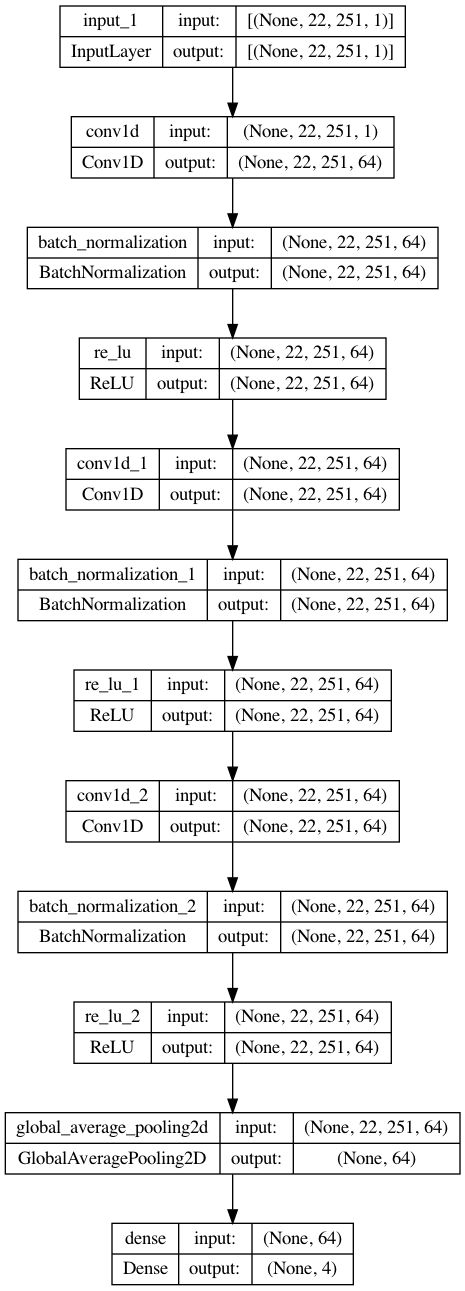

In [5]:
model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [8]:
epochs = 100
batch_size = 16 #32

checkpointer = keras.callbacks.ModelCheckpoint(filepath='tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy', 'TruePositives', 'TrueNegatives'])

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=checkpointer,
    validation_data=(X_validate, Y_validate), #validation_split=0.2,
    verbose=2, #1
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.38508, saving model to tmp/checkpoint.h5
9/9 - 4s - loss: 1.3972 - accuracy: 0.2569 - true_positives: 1.0000 - true_negatives: 432.0000 - val_loss: 1.3851 - val_accuracy: 0.2639 - val_true_positives: 0.0000e+00 - val_true_negatives: 216.0000 - 4s/epoch - 499ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.38508
9/9 - 3s - loss: 1.3681 - accuracy: 0.3125 - true_positives: 1.0000 - true_negatives: 432.0000 - val_loss: 1.3855 - val_accuracy: 0.2639 - val_true_positives: 0.0000e+00 - val_true_negatives: 216.0000 - 3s/epoch - 328ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.38508
9/9 - 3s - loss: 1.3608 - accuracy: 0.3056 - true_positives: 1.0000 - true_negatives: 432.0000 - val_loss: 1.3860 - val_accuracy: 0.2639 - val_true_positives: 0.0000e+00 - val_true_negatives: 216.0000 - 3s/epoch - 352ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.38508
9/9 - 3s - loss: 1.3538 - accuracy: 0.2778 - true_

## Evaluate model on test data

In [9]:
# load optimal weights
model.load_weights('tmp/checkpoint.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 73ms/step
Classification accuracy: 0.236111 
